In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
import pandas as pd
%matplotlib inline

In [2]:
from scipy.optimize import curve_fit
def line(x, a, b):
    return a*x + b

def wrapRad(theta):
#     return theta % (2*np.pi)
    return (theta + np.pi) % (2*np.pi) - np.pi

$$\vec{e_1} = e_1 e^{i\varpi_1}$$
$$\tilde{\vec{e_{1}}} = \vec{e_1}-\vec{e}, \qquad \tilde{\vec{e_{2}}} = \vec{e_2}-\vec{e}$$

In [15]:
def simNoForce(P1, P2, ecc, pom, scale):
    mu1, mu2 = 36e-6, 28e-6
    ecc1, ecc0, ecc2 = ecc
    pomega1, pomega0, pomega2 = pom
    P_0 = 0.05
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    # add test particle
    sim.add(P=P_0, e=ecc0, pomega=pomega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=400
    pomega1, pomega2, ecc1, ecc2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_0 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            p0, p1, p2, e0, e1, e2 = info_0.pomega, info_1.pomega, info_2.pomega, info_0.e, info_1.e, info_2.e
            e10_y = (e0*np.sin(p0)-e1*np.sin(p1))
            e10_x = (e0*np.cos(p0)-e1*np.cos(p1))
            e20_y = (e2*np.sin(p0)-e0*np.sin(p2))
            e20_x = (e2*np.cos(p0)-e0*np.cos(p2))
            pomega1[i] = np.arctan2(e10_y,e10_x)
            pomega2[i] = np.arctan2(e20_y,e20_x)
            ecc1[i] = np.sqrt(e10_x**2 + e10_y**2)
            ecc2[i] = np.sqrt(e20_x**2 + e20_y**2)
        except rebound.Collision:
            break
    
    return times, pomega1, pomega2, ecc1, ecc2   

In [16]:
def simWithForce(P1, P2, gamma, A, ecc, pom, scale):
    mu1, mu2 = 36e-6, 28e-6
    ecc1, ecc0, ecc2 = ecc
    pomega1, pomega0, pomega2 = pom
    P_0 = 0.05
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    # add test particle
    sim.add(P=P_0, e=ecc0, pomega=pomega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=400
    pomega1, pomega2, ecc1, ecc2 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    times = np.linspace(0,scale,Nout)
    
    rebx = reboundx.Extras(sim)
    cf = rebx.load_force("central_force")
    rebx.add_force(cf)
    
    ps[0].params["gammacentral"] = gamma
    ps[0].params["Acentral"] = A
#     pomegadot = A # has dimensions of inverse time, in whatever units the simulation uses.
#     ps[0].params["Acentral"] = rebx.central_force_Acentral(ps[3], ps[0], pomegadot, ps[0].params["gammacentral"])
    print(ps[0].params["Acentral"])
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_0 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            p0, p1, p2, e0, e1, e2 = info_0.pomega, info_1.pomega, info_2.pomega, info_0.e, info_1.e, info_2.e
            e10_y = (e0*np.sin(p0)-e1*np.sin(p1))
            e10_x = (e0*np.cos(p0)-e1*np.cos(p1))
            e20_y = (e2*np.sin(p0)-e0*np.sin(p2))
            e20_x = (e2*np.cos(p0)-e0*np.cos(p2))
            pomega1[i] = np.arctan2(e10_y,e10_x)
            pomega2[i] = np.arctan2(e20_y,e20_x)
            ecc1[i] = np.sqrt(e10_x**2 + e10_y**2)
            ecc2[i] = np.sqrt(e20_x**2 + e20_y**2)
        except rebound.Collision:
            break
    
    return times, pomega1, pomega2, ecc1, ecc2

In [17]:
def compare(P1, P2, gamma, A, ecc, pom, scale):
    fig, axarr = plt.subplots(nrows=4, figsize=(12,10))
    times, pomega1, pomega2, ecc1, ecc2, = simNoForce(P1,P2, ecc, pom, scale)
    times_f, pomega1_f, pomega2_f, ecc1_f, ecc2_f = simWithForce(P1,P2,gamma,A,ecc,pom,scale)
    axarr[0].plot(times, pomega1, 'k.')
    axarr[0].plot(times_f, pomega1_f, 'b.')
    axarr[0].set_ylabel(r"$\varpi_{01}$")
    
    axarr[1].plot(times, pomega2, 'k.')
    axarr[1].plot(times_f, pomega2_f, 'b.')
    axarr[1].set_ylabel(r"$\varpi_{02}$")
    
    axarr[2].plot(times, ecc1, 'k.')  
    axarr[2].plot(times_f, ecc1_f, 'b.')
    axarr[2].set_ylabel('ecc1')
    
    axarr[3].plot(times, ecc2, 'k.')
    axarr[3].plot(times_f, ecc2_f, 'b.')
    axarr[3].set_ylabel('ecc2')
    axarr[3].set_xlabel('time (yr)')

0.00025


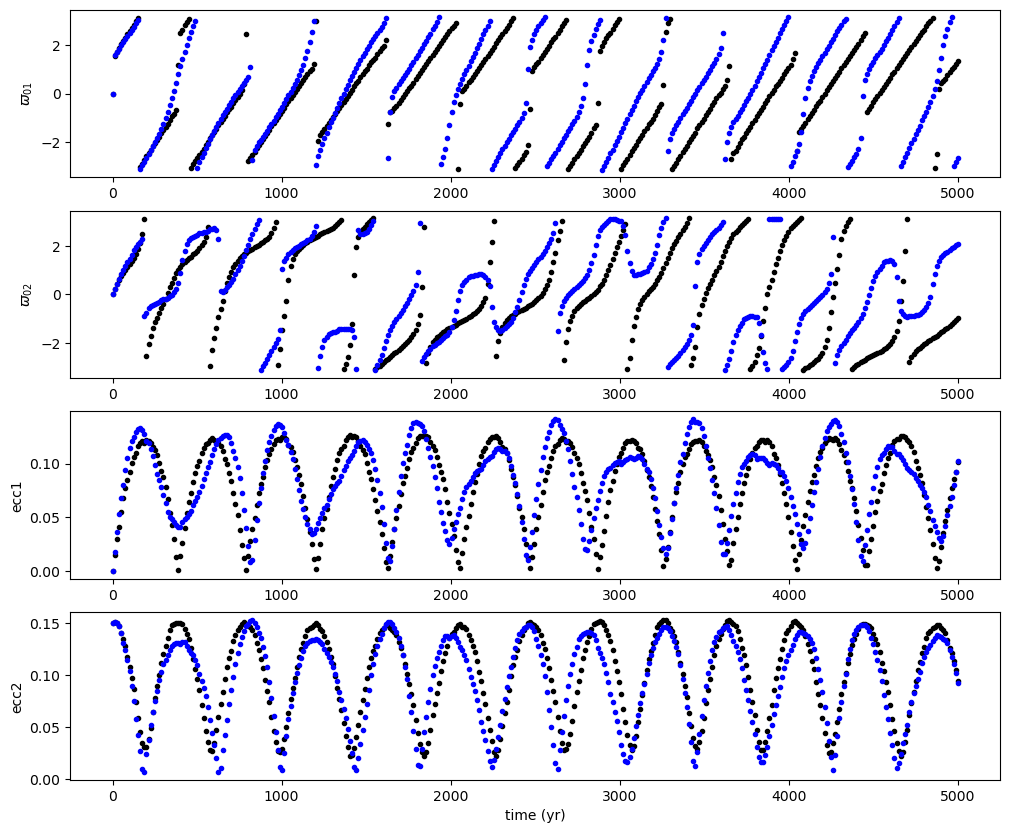

In [18]:
compare(0.05*0.65, 0.05*1.55, -3, 2.5e-4, (0.05,0.05,0.1),(0,0,np.pi), 0.05*1e5)